In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
modver = '202007H'
datespan = '20150101-20151231'
matchpath='/home/sallen/202007/202007H/ObsModel_202007H_bot_20150101_20151231.csv'
data=pd.read_csv(matchpath,index_col=0)
data.dropna(axis=1,how='all',inplace=True)
data['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') for ii in data['dtUTC']]

In [3]:
display(Markdown('''### DFO Comparisons '''))
display(Markdown('''###   ''' + modver))
display(Markdown('''###    '''+ str(datespan)))
display(Markdown('''####   File: '''+ matchpath))

### DFO Comparisons 

###   202007H

###    20150101-20151231

####   File: /home/sallen/202007/202007H/ObsModel_202007H_bot_20150101_20151231.csv

In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [5]:
print('Fields available:')
print([el for el in data.keys()])

Fields available:
['Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Pressure', 'Chlorophyll_Extracted', 'Chlorophyll_Extracted_units', 'N', 'Si', 'Silicate_units', 'AbsSal', 'ConsT', 'Z', 'dtUTC', 'j', 'i', 'mod_nitrate', 'mod_silicon', 'mod_ammonium', 'mod_diatoms', 'mod_ciliates', 'mod_flagellates', 'mod_vosaline', 'mod_votemper', 'mod_dissolved_oxygen', 'k']


In [6]:
df1=et.loadDFO(datelims=(dt.datetime(2015,1,1),dt.datetime(2015,12,31)))

In [7]:
df1.keys()

Index(['Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Pressure', 'Depth',
       'Chlorophyll_Extracted', 'Chlorophyll_Extracted_units', 'N', 'Si',
       'Silicate_units', 'AbsSal', 'ConsT', 'Oxygen_Dissolved',
       'Oxygen_Dissolved_units', 'Z', 'dtUTC'],
      dtype='object')

In [8]:
len(df1.loc[df1.Oxygen_Dissolved>=0])

468

In [9]:
data['rHour']=[np.round(ii,4) for ii in data['Hour']]
data['rLat']=[np.round(ii,5) for ii in data['Lat']]
data['rLon']=[np.round(ii,5) for ii in data['Lon']]
data['rPressure']=[np.round(ii,4) for ii in data['Pressure']]
data['rZ']=[np.round(ii,4) for ii in data['Z']]
data['rSi']=[np.round(ii,4) for ii in data['Si']]
data['rN']=[np.round(ii,4) for ii in data['N']]

df1['rHour']=[np.round(ii,4) for ii in df1['Hour']]
df1['rLat']=[np.round(ii,5) for ii in df1['Lat']]
df1['rLon']=[np.round(ii,5) for ii in df1['Lon']]
df1['rPressure']=[np.round(ii,4) for ii in df1['Pressure']]
df1['rZ']=[np.round(ii,4) for ii in df1['Z']]
df1['rSi']=[np.round(ii,4) for ii in df1['Si']]
df1['rN']=[np.round(ii,4) for ii in df1['N']]

In [10]:
len(data[['Year','Month','Day','rHour','rLat','rLon','rPressure','rZ','rSi','rN']].drop_duplicates())

566

In [11]:
len(df1[['Year','Month','Day','rHour','rLat','rLon','rPressure','rZ','rSi','rN']].drop_duplicates())

566

In [12]:
len(df1),len(data)

(569, 569)

In [13]:
df1.drop_duplicates(subset=['Year','Month','Day','rHour','rLat','rLon','rPressure','rZ','rSi','rN'],keep='first',inplace=True)

In [14]:
data.drop_duplicates(subset=['Year','Month','Day','rHour','rLat','rLon','rPressure','rZ','rSi','rN'],keep='first',inplace=True)

In [15]:
data2=pd.merge(left=data,right=df1,how='left',
               left_on=['Year','Month','Day','rHour','rLat','rLon','rPressure','rZ','rSi','rN'],
               right_on=['Year','Month','Day','rHour','rLat','rLon','rPressure','rZ','rSi','rN'],suffixes=('','_2'))

In [16]:
len(data),len(df1),len(data2)

(566, 566, 566)

In [17]:
len(data2.loc[data2.Oxygen_Dissolved>=0])

468

In [18]:
data=data2.copy(deep=True)

In [19]:
# density calculations:
data['rho']=gsw.rho(data['AbsSal'],data['ConsT'],data['Pressure'])
data['mod_rho']=gsw.rho(data['mod_vosaline'],data['mod_votemper'],
                        gsw.p_from_z(-1*data['Z'],data['Lat']))

In [20]:
# umol/kg * kg/m3 *m3/L=umol/L= oxy0*rho/1000
data['Oxy_uM']=data['Oxygen_Dissolved']*data['rho']/1e3
#data['CTDOxy_uM']=data['Oxygen_Dissolved_SBE']*data['rho']/1e3

In [21]:
# load chl to N ratio from namelist
mod_chl_N=1.8

In [22]:
# chlorophyll calculations
data['l10_obsChl']=np.log10(data['Chlorophyll_Extracted']+0.01)
data['l10_modChl']=np.log10(mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])+0.01)
data['mod_Chl']=mod_chl_N*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])
data['Chl']=data['Chlorophyll_Extracted']

In [23]:
cm1=cmocean.cm.thermal
year=data.dtUTC[0].year
theta=-30
lon0=-123.9
lat0=49.3
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [24]:
def byDepth(ax,obsvar,modvar,lims):
    ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
    l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(ax,obsvar,modvar,lims):
    ps1=et.varvarPlot(ax,dJDF,obsvar,modvar,cols=('b',),lname='SJDF')
    ps2=et.varvarPlot(ax,dSJGI,obsvar,modvar,cols=('c',),lname='SJGI')
    ps3=et.varvarPlot(ax,dSOG,obsvar,modvar,cols=('y',),lname='SOG')
    ps4=et.varvarPlot(ax,dNSOG,obsvar,modvar,cols=('m',),lname='NSOG')
    l=ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return (ps1,ps2,ps3,ps4),l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

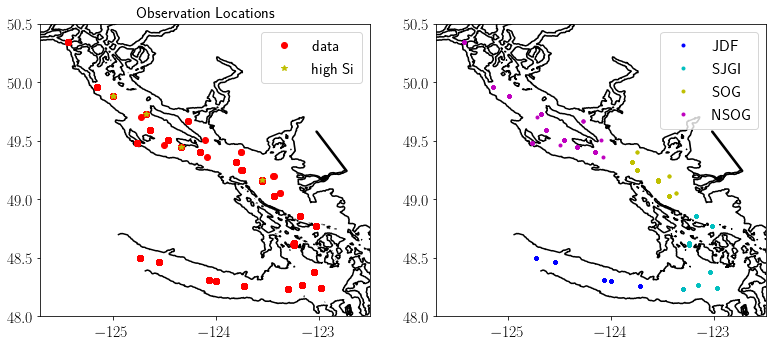

In [25]:
fig, ax = plt.subplots(1,2,figsize = (13,6))
viz_tools.set_aspect(ax[0], coords = 'map')
ax[0].plot(data['Lon'], data['Lat'], 'ro',label='data')
ax[0].plot(data.loc[data.Si>75,['Lon']],data.loc[data.Si>75,['Lat']],'*',color='y',label='high Si')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax[0], grid, coords = 'map',isobath=.1)
ax[0].set_ylim(48, 50.5)
ax[0].legend()
ax[0].set_xlim(-125.7, -122.5);
ax[0].set_title('Observation Locations');

viz_tools.set_aspect(ax[1], coords = 'map')
#ax[1].plot(data['Lon'], data['Lat'], 'ro',label='data')
dJDF=data.loc[(data.Lon<-123.3)&(data.Lat<48.6)]
ax[1].plot(dJDF['Lon'],dJDF['Lat'],'b.',label='JDF')
dSJGI=data.loc[(data.Lon>=-123.6)&(data.Lat<48.9)]
ax[1].plot(dSJGI['Lon'],dSJGI['Lat'],'c.',label='SJGI')
dSOG=data.loc[(data.Lat>=48.9)&(data.Lon>-124.0)]
ax[1].plot(dSOG['Lon'],dSOG['Lat'],'y.',label='SOG')
dNSOG=data.loc[(data.Lat>=48.9)&(data.Lon<=-124.0)]
ax[1].plot(dNSOG['Lon'],dNSOG['Lat'],'m.',label='NSOG')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax[1], grid, coords = 'map')
ax[1].set_ylim(48, 50.5)
ax[1].legend()
ax[1].set_xlim(-125.7, -122.5);

# Also set up seasonal groupings:
iz=(data.Z<15)
JFM=data.loc[iz&(data.dtUTC<=dt.datetime(year,4,1)),:]
Apr=data.loc[iz&(data.dtUTC<=dt.datetime(year,5,1))&(data.dtUTC>dt.datetime(year,4,1)),:]
MJJA=data.loc[iz&(data.dtUTC<=dt.datetime(year,9,1))&(data.dtUTC>dt.datetime(year,5,1)),:]
SOND=data.loc[iz&(data.dtUTC>dt.datetime(year,9,1)),:]

In [26]:
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, JFM':JFM,
                      'z < 15 m, Apr':Apr,
                      'z < 15 m, MJJA':MJJA,
                      'z < 15 m, SOND': SOND,
                      'SJDF':dJDF,
                      'SJGI':dSJGI,
                      'SOG':dSOG,
                      'NSOG':dNSOG})

# Nitrate

In [27]:
obsvar='N'
modvar='mod_nitrate'
statsDict={year:dict()}
statsDict[year]['NO3']=OrderedDict()
for isub in statsubs:
    statsDict[year]['NO3'][isub]=dict()
    var=statsDict[year]['NO3'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['NO3'],level='Subset',suborder=list(statsubs.keys()))
tbl

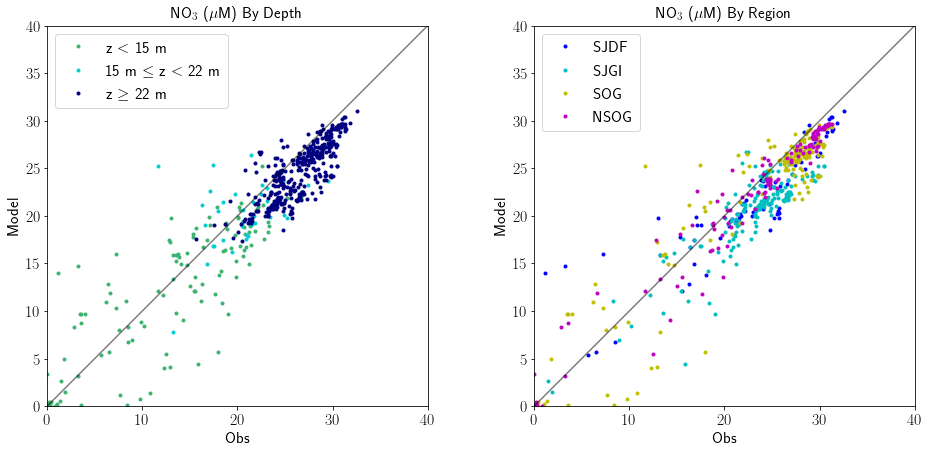

In [28]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(0,40))
ax[0].set_title('NO$_3$ ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,40))
ax[1].set_title('NO$_3$ ($\mu$M) By Region');

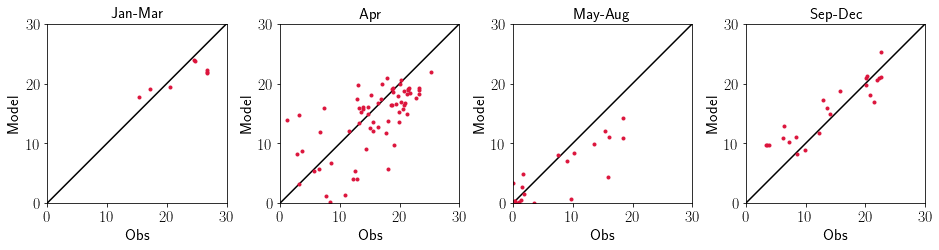

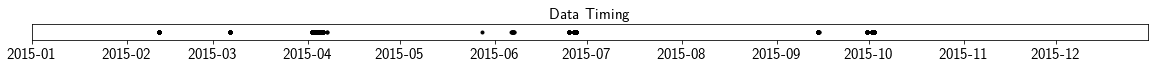

In [29]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(0,30))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

# Dissolved Silica

In [30]:
obsvar='Si'
modvar='mod_silicon'
statsDict[year]['dSi']=OrderedDict()
for isub in statsubs:
    statsDict[year]['dSi'][isub]=dict()
    var=statsDict[year]['dSi'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['dSi'],level='Subset',suborder=list(statsubs.keys()))
tbl

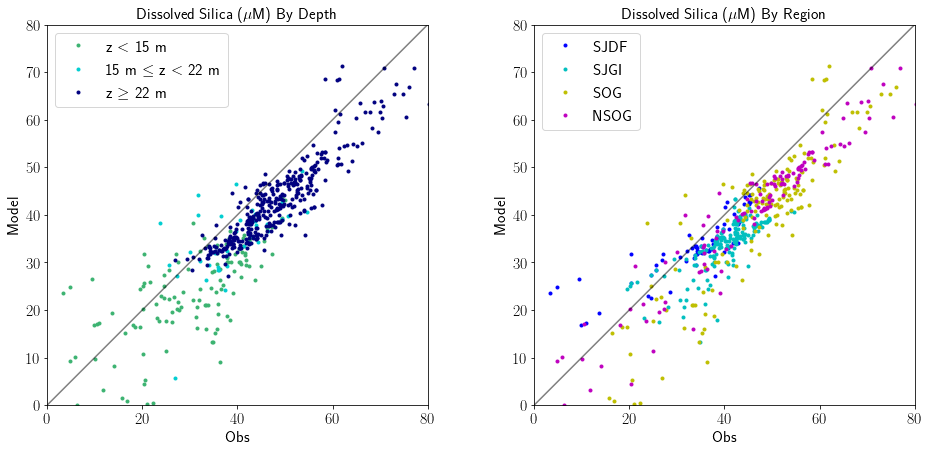

In [31]:
mv=(0,80)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,mv)
ax[0].set_title('Dissolved Silica ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,mv)
ax[1].set_title('Dissolved Silica ($\mu$M) By Region');

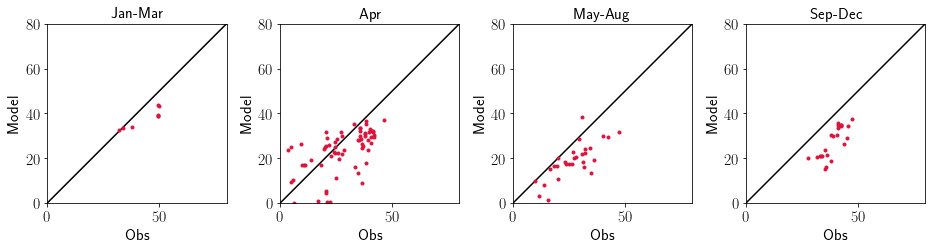

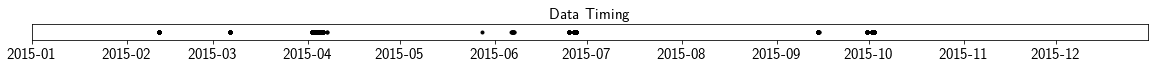

In [32]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Profiles of NO3 and Dissolved Silica

(-150, 50)

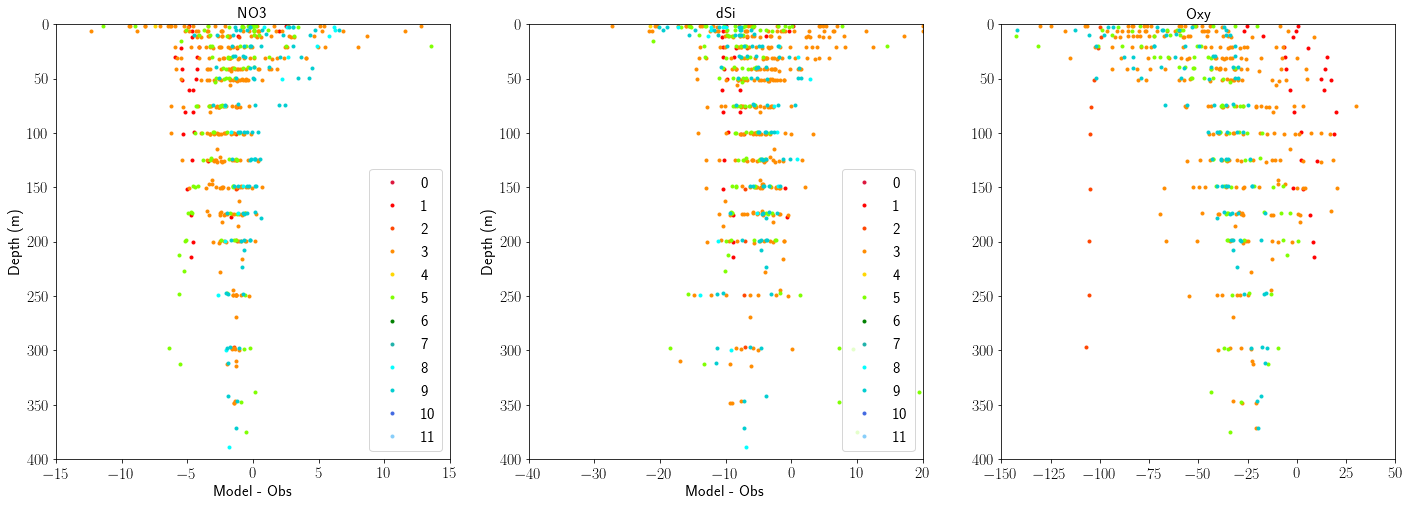

In [56]:
fig, ax = plt.subplots(1,3,figsize = (24,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'darkturquoise','royalblue','lightskyblue','blue','darkblue','mediumslateblue','blueviolet',
      'darkmagenta','fuchsia','deeppink','pink')
start_date=dt.datetime(np.min(data['dtUTC']).year,1,1)
end_date=dt.datetime(np.max(data['dtUTC']).year+1,1,1)
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['N']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[2].plot(data.loc[iii,['mod_dissolved_oxygen']].values-data.loc[iii,['Oxy_uM']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(400,0)
    axi.set_ylabel('Depth (m)')
ax[0].set_xlabel('Model - Obs')
ax[1].set_xlabel('Model - Obs')
ax[0].set_xlim(-15,15)
ax[1].set_xlim(-40,20)
ax[0].set_title('NO3')
ax[1].set_title('dSi')
ax[2].set_title('Oxy')
ax[2].set_ylim(400,0)
ax[2].set_xlim(-150,50)

In [66]:
eps

-0.7997266612474343

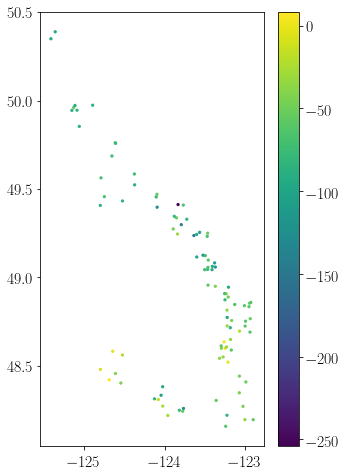

In [71]:
fig,ax=plt.subplots(1,1,figsize=(5,8))
idata=data.loc[data.Z<15]
eps=np.random.uniform(-.1,.1,size=len(idata))
eps2=np.random.uniform(-.1,.1,size=len(idata))
m=ax.scatter(idata['Lon']+eps,idata['Lat']+eps2,c=idata['mod_dissolved_oxygen']-idata['Oxy_uM'],s=5)
fig.colorbar(m,ax=ax)

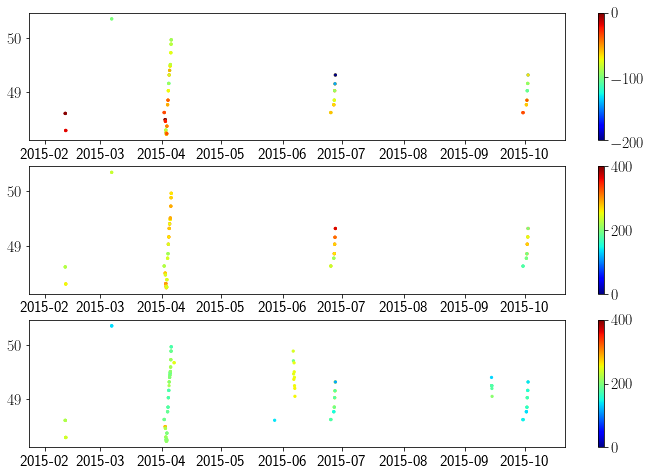

In [84]:
fig,ax=plt.subplots(3,1,figsize=(12,8))
cm=plt.get_cmap('jet')
idata=data.loc[data.Z<15]
m0=ax[0].scatter(idata['dtUTC'],idata['Lat'],c=idata['mod_dissolved_oxygen']-idata['Oxy_uM'],
                 s=5,vmin=-200,vmax=0,cmap=cm)
fig.colorbar(m0,ax=ax[0])
m1=ax[1].scatter(idata['dtUTC'],idata['Lat'],c=idata['Oxy_uM'],s=5,vmin=0,vmax=400,cmap=cm)
fig.colorbar(m1,ax=ax[1])
m2=ax[2].scatter(idata['dtUTC'],idata['Lat'],c=idata['mod_dissolved_oxygen'],s=5,vmin=0,vmax=400,cmap=cm)
fig.colorbar(m2,ax=ax[2])

# dSi:NO3 Ratios

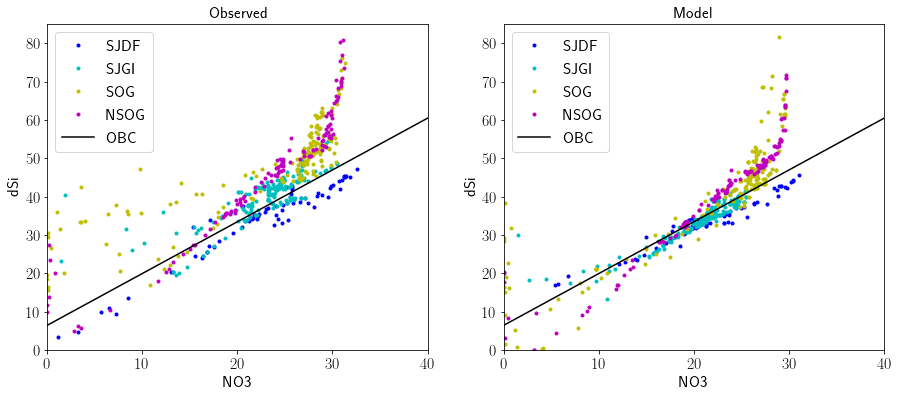

In [34]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
p1=ax[0].plot(dJDF['N'],dJDF['Si'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['N'],dSJGI['Si'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['N'],dSOG['Si'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['N'],dNSOG['Si'],'m.',label='NSOG')
ax[0].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[0].set_title('Observed')
ax[0].set_xlabel('NO3')
ax[0].set_ylabel('dSi')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_nitrate'],dJDF['mod_silicon'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_nitrate'],dSJGI['mod_silicon'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_nitrate'],dSOG['mod_silicon'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_nitrate'],dNSOG['mod_silicon'],'m.',label='NSOG')
ax[1].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('NO3')
ax[1].set_ylabel('dSi')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
#ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
#ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

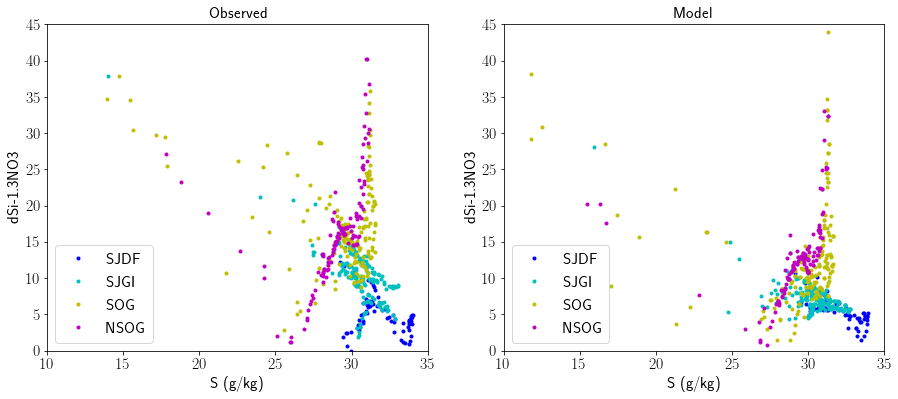

In [35]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
p1=ax[0].plot(dJDF['AbsSal'], dJDF['Si']-1.3*dJDF['N'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['AbsSal'],dSJGI['Si']-1.3*dSJGI['N'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['AbsSal'],dSOG['Si']-1.3*dSOG['N'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['AbsSal'],dNSOG['Si']-1.3*dNSOG['N'],'m.',label='NSOG')
ax[0].set_title('Observed')
ax[0].set_xlabel('S (g/kg)')
ax[0].set_ylabel('dSi-1.3NO3')
ax[0].set_xlim(10,35)
ax[0].set_ylim(0,45)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_vosaline'],dJDF['mod_silicon']-1.3*dJDF['mod_nitrate'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_vosaline'],dSJGI['mod_silicon']-1.3*dSJGI['mod_nitrate'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_vosaline'],dSOG['mod_silicon']-1.3*dSOG['mod_nitrate'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_vosaline'],dNSOG['mod_silicon']-1.3*dNSOG['mod_nitrate'],'m.',label='NSOG')
ax[1].set_title('Model')
ax[1].set_xlabel('S (g/kg)')
ax[1].set_ylabel('dSi-1.3NO3')
ax[1].set_xlim(10,35)
ax[1].set_ylim(0,45)
ax[1].legend()

In [36]:
data.keys()

Index(['Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Pressure',
       'Chlorophyll_Extracted', 'Chlorophyll_Extracted_units', 'N', 'Si',
       'Silicate_units', 'AbsSal', 'ConsT', 'Z', 'dtUTC', 'j', 'i',
       'mod_nitrate', 'mod_silicon', 'mod_ammonium', 'mod_diatoms',
       'mod_ciliates', 'mod_flagellates', 'mod_vosaline', 'mod_votemper',
       'mod_dissolved_oxygen', 'k', 'rHour', 'rLat', 'rLon', 'rPressure', 'rZ',
       'rSi', 'rN', 'Hour_2', 'Lat_2', 'Lon_2', 'Pressure_2', 'Depth',
       'Chlorophyll_Extracted_2', 'Chlorophyll_Extracted_units_2', 'N_2',
       'Si_2', 'Silicate_units_2', 'AbsSal_2', 'ConsT_2', 'Oxygen_Dissolved',
       'Oxygen_Dissolved_units', 'Z_2', 'dtUTC_2', 'rho', 'mod_rho', 'Oxy_uM',
       'l10_obsChl', 'l10_modChl', 'mod_Chl', 'Chl'],
      dtype='object')

# Oxygen

In [37]:
obsvar='Oxy_uM'
modvar='mod_dissolved_oxygen'
statsDict={year:dict()}
statsDict[year]['Oxy']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Oxy'][isub]=dict()
    var=statsDict[year]['Oxy'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['Oxy'],level='Subset',suborder=list(statsubs.keys()))
tbl

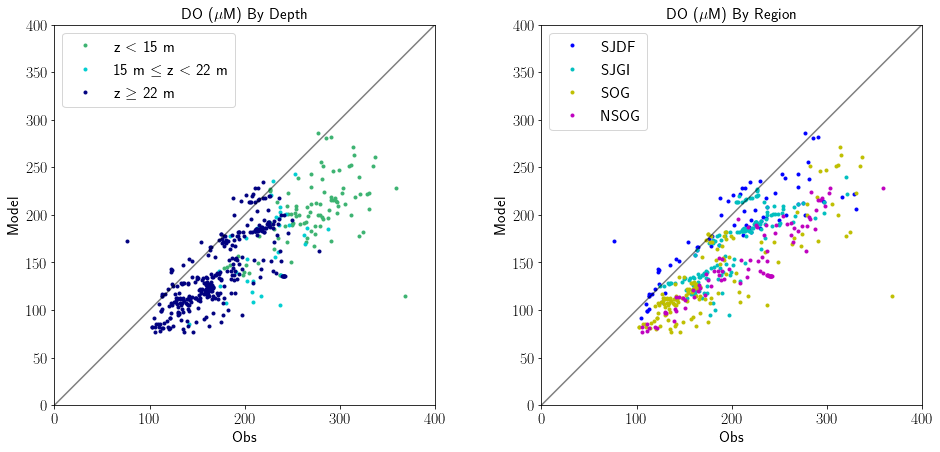

In [38]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(0,400))
ax[0].set_title('DO ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,400))
ax[1].set_title('DO ($\mu$M) By Region');

# Chlorophyll

In [39]:
obsvar='l10_obsChl'
modvar='l10_modChl'
statsDict[year]['Chl log10']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Chl log10'][isub]=dict()
    var=statsDict[year]['Chl log10'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
obsvar='Chlorophyll_Extracted'
modvar='mod_Chl'
statsDict[year]['Chl']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Chl'][isub]=dict()
    var=statsDict[year]['Chl'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])

tempD={'Chl log10':statsDict[year]['Chl log10'],'Chl':statsDict[year]['Chl']}
tbl,tdf=et.displayStatsFlex(tempD,('Variable','Subset','Metric',''),
                        ['Order','Subset','Metric'],
                        ['Variable','Metric'],
                        suborder=list(statsubs.keys()))
tbl

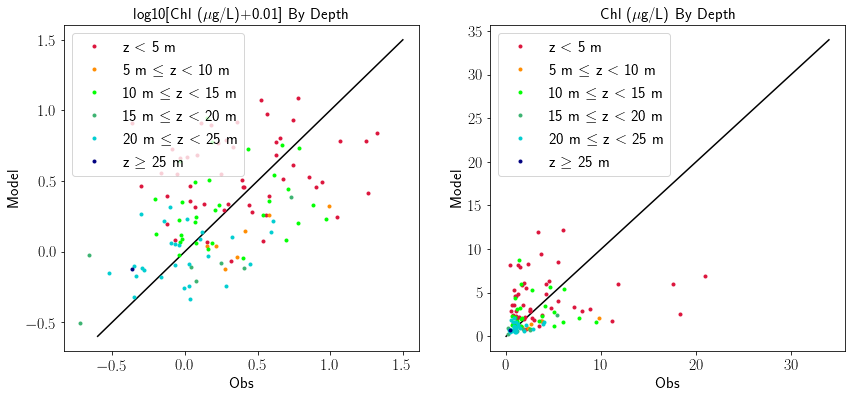

In [40]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
ax[0].plot(np.arange(-.6,1.6,.1),np.arange(-.6,1.6,.1),'k-')
ps=et.varvarPlot(ax[0],data,'l10_obsChl','l10_modChl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('log10[Chl ($\mu$g/L)+0.01] By Depth')
ax[1].plot(np.arange(0,35),np.arange(0,35),'k-')
ps=et.varvarPlot(ax[1],data,'Chlorophyll_Extracted','mod_Chl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('Chl ($\mu$g/L) By Depth');

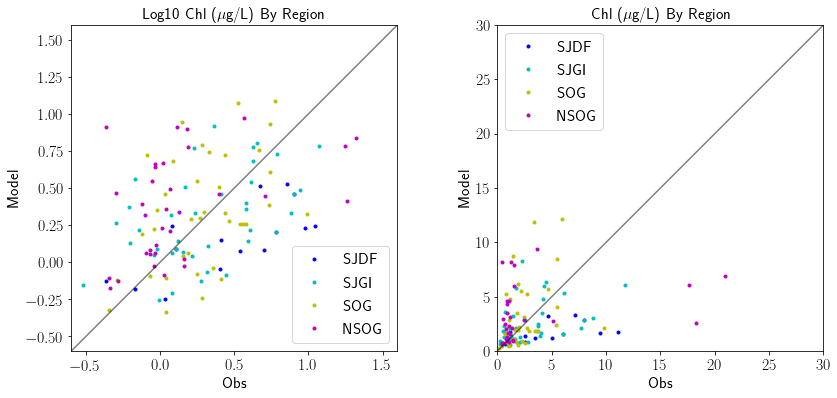

In [41]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
obsvar='l10_obsChl'; modvar='l10_modChl'
ps,l=byRegion(ax[0],obsvar,modvar,(-.6,1.6))
ax[0].set_title('Log10 Chl ($\mu$g/L) By Region');

obsvar='Chlorophyll_Extracted'; modvar='mod_Chl'
ps,l=byRegion(ax[1],obsvar,modvar,(0,30))
ax[1].set_title('Chl ($\mu$g/L) By Region');

(-15, 15)

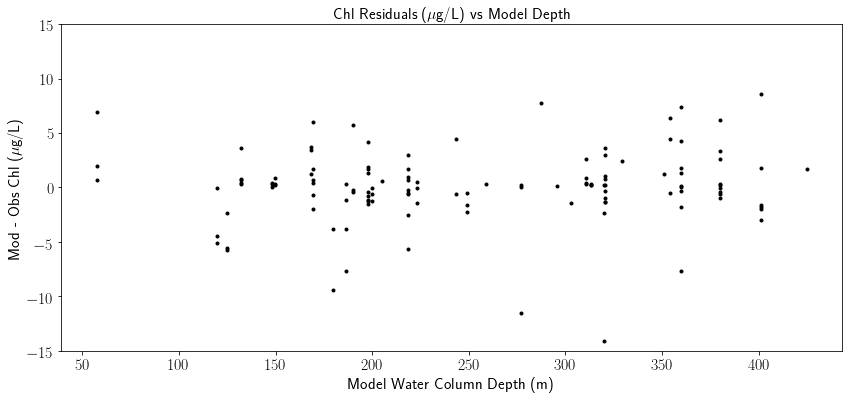

In [42]:
fig, ax = plt.subplots(1,1,figsize = (14,6))
obsvar='l10_obsChl'; modvar='l10_modChl'
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc') as fm:
    bathy=np.sum(fm.variables['tmask'][0,:,:,:]*fm.variables['e3t_0'][0,:,:,:],0)
data['bathy']=[bathy[j,i] for j,i in zip(data['j'],data['i'])]
ax.plot(data['bathy'],data['mod_Chl']-data['Chl'],'k.')
ax.set_title('Chl Residuals ($\mu$g/L) vs Model Depth');
ax.set_xlabel('Model Water Column Depth (m)')
ax.set_ylabel('Mod - Obs Chl ($\mu$g/L)');
ax.set_ylim(-15,15)

## Conservative Temperature 

In [43]:
obsvar='ConsT'
modvar='mod_votemper'
statsDict[year]['Temperature']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Temperature'][isub]=dict()
    var=statsDict[year]['Temperature'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['Temperature'],level='Subset',suborder=list(statsubs.keys()))
tbl

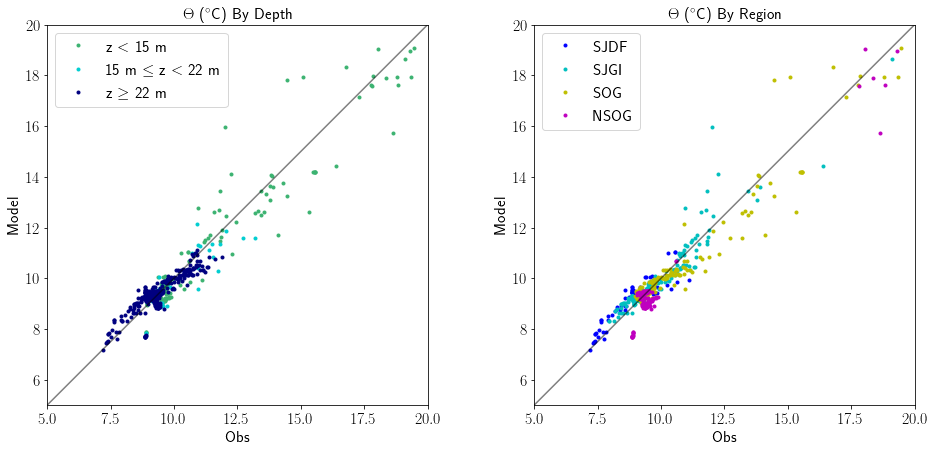

In [44]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(5,20))
ax[0].set_title('$\Theta$ ($^{\circ}$C) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(5,20))
ax[1].set_title('$\Theta$ ($^{\circ}$C) By Region');

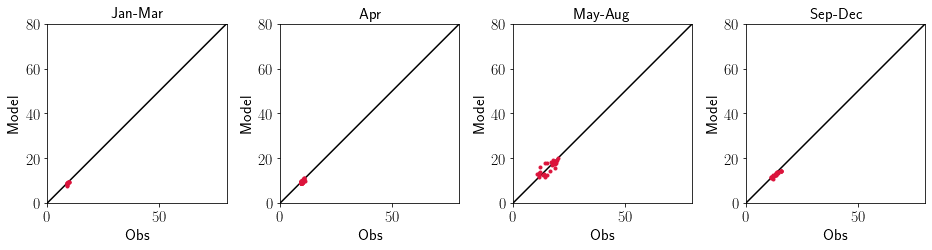

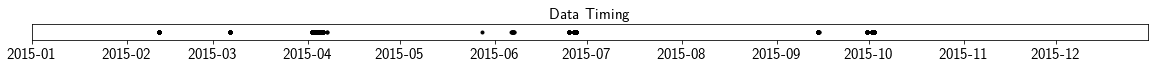

In [45]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

## Reference Salinity

In [46]:
obsvar='AbsSal'
modvar='mod_vosaline'
statsDict[year]['Salinity']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Salinity'][isub]=dict()
    var=statsDict[year]['Salinity'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['Salinity'],level='Subset',suborder=list(statsubs.keys()))
tbl

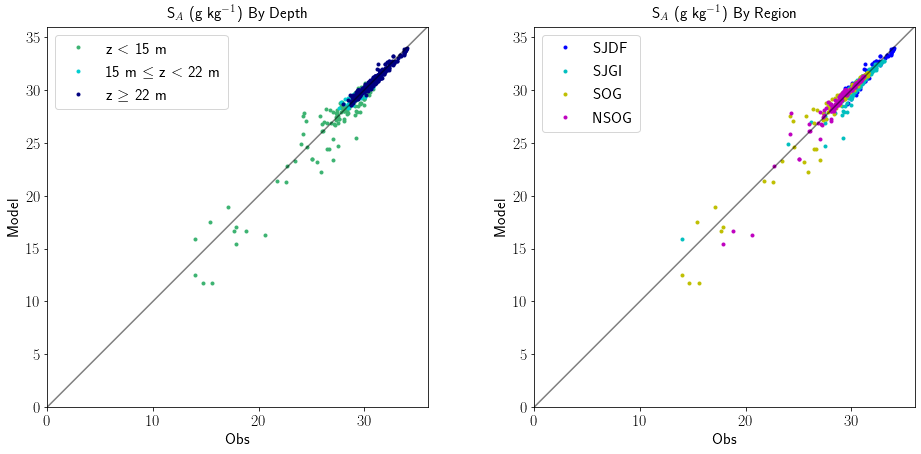

In [47]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(0,36))
ax[0].set_title('S$_A$ (g kg$^{-1}$) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,36))
ax[1].set_title('S$_A$ (g kg$^{-1}$) By Region');

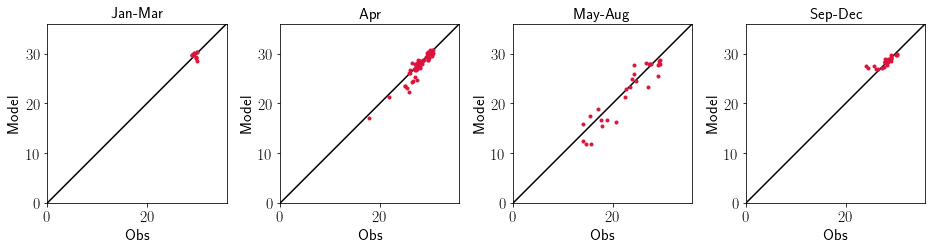

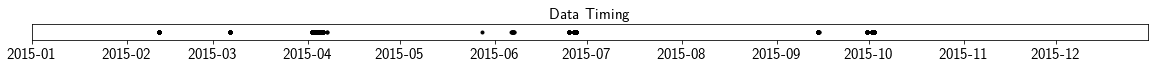

In [48]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(0,36))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Density

In [49]:
obsvar='rho'
modvar='mod_rho'
statsDict[year]['Density']=OrderedDict()
for isub in statsubs:
    statsDict[year]['Density'][isub]=dict()
    var=statsDict[year]['Density'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['Density'],level='Subset',suborder=list(statsubs.keys()))
tbl

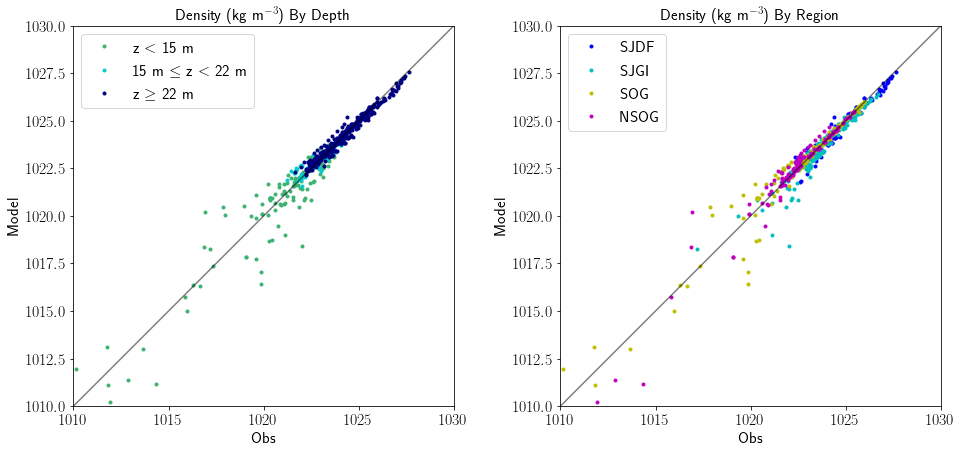

In [50]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(1010,1030))
ax[0].set_title('Density (kg m$^{-3}$) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(1010,1030))
ax[1].set_title('Density (kg m$^{-3}$) By Region');

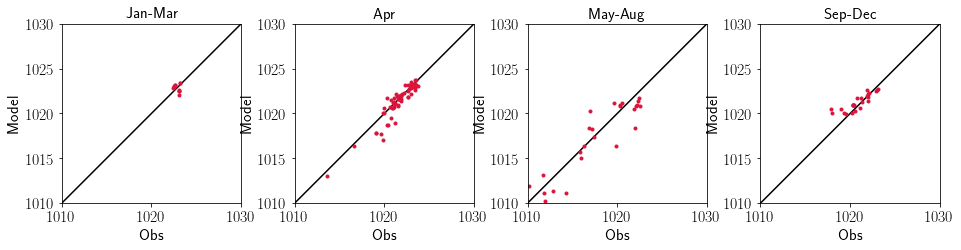

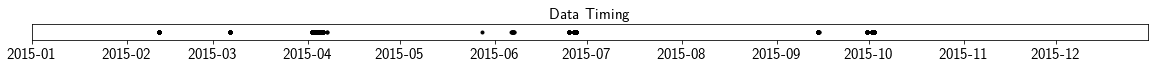

In [51]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(1010,1030))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Temperature-Salinity by Region

In [52]:
def tsplot(ax,svar,tvar):
    limsS=(0,36)
    limsT=(5,20)
    ss,tt=np.meshgrid(np.linspace(limsS[0],limsS[1],20),np.linspace(limsT[0],limsT[1],20))
    rho=gsw.rho(ss,tt,np.zeros(np.shape(ss)))
    r=ax.contour(ss,tt,rho,colors='k')
    ps1=ax.plot(dJDF[svar],dJDF[tvar],'b.',label='SJDF')
    ps2=ax.plot(dSJGI[svar],dSJGI[tvar],'c.',label='SJGI')
    ps3=ax.plot(dSOG[svar],dSOG[tvar],'y.',label='SOG')
    ps4=ax.plot(dNSOG[svar],dNSOG[tvar],'m.',label='NSOG')
    l=ax.legend(handles=[ps1[0],ps2[0],ps3[0],ps4[0]],bbox_to_anchor=(1.55,1))
    ax.set_ylim(limsT)
    ax.set_xlim(limsS)
    ax.set_ylabel('$\Theta$ ($^{\circ}$C)')
    ax.set_xlabel('S$_A$ (g kg$^{-1}$)')
    ax.set_aspect((limsS[1]-limsS[0])/(limsT[1]-limsT[0]))
    return

Text(0.5, 1.0, 'Modelled')

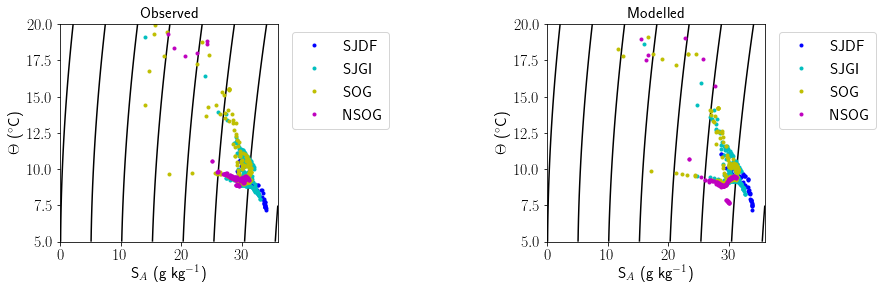

In [53]:
fig,ax=plt.subplots(1,2,figsize=(16,4))
tsplot(ax[0],'AbsSal','ConsT')
ax[0].set_title('Observed')
tsplot(ax[1],'mod_vosaline','mod_votemper')
ax[1].set_title('Modelled')

### Display All Stats

In [54]:
tbl,tdf=et.displayStats(statsDict[year],level='Variable',suborder=list(statsubs.keys()))
tbl